In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm

# Set seed
torch.manual_seed(42)

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Directories
train_dir = r"C:\Users\Kunal\OneDrive\Desktop\Pythom\Practical Example Regerssion\Alzhimer problem\Dataset\Combined Dataset\train"
test_dir = r"C:\Users\Kunal\OneDrive\Desktop\Pythom\Practical Example Regerssion\Alzhimer problem\Dataset\Combined Dataset\test"

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 4
EPOCHS = 20
PATIENCE = 5

# Transforms
train_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(40),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.2, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load full training dataset (with train transforms for now)
full_train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)

# Extract targets for stratification
targets = np.array([label for _, label in full_train_dataset])
indices = np.arange(len(full_train_dataset))

# Train-validation split
train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    stratify=targets,
    random_state=42
)

# Subsets
train_dataset = Subset(full_train_dataset, train_idx)

# Create validation dataset with different transform (test_transforms)
val_dataset = Subset(datasets.ImageFolder(train_dir, transform=test_transforms), val_idx)

# Test dataset
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [2]:
#from sklearn.metrics import classification_report

# After evaluation
#print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))


In [3]:

class KorolevModel(nn.Module):
    """The model used in Korolev et al. 2017 (https://arxiv.org/abs/1701.06643)."""
    def __init__(self):
        nn.Module.__init__(self)
        
        self.relu = nn.ReLU()
        
        self.conv = nn.Sequential(
            nn.Conv3d(1, 8, 3),
            self.relu,
            nn.Conv3d(8, 8, 3),
            self.relu,
            nn.BatchNorm3d(8),
            nn.MaxPool3d(2),  
            
            nn.Conv3d(8, 16, 3),
            self.relu,
            nn.Conv3d(16, 16, 3),
            self.relu,
            nn.BatchNorm3d(16),
            nn.MaxPool3d(2),
            
            nn.Conv3d(16, 32, 3),
            self.relu,
            nn.Conv3d(32, 32, 3),
            self.relu,
            nn.Conv3d(32, 32, 3),
            self.relu,
            nn.BatchNorm3d(32),
            nn.MaxPool3d(2),
            
            nn.Conv3d(32, 64, 3),
            self.relu,
            nn.Conv3d(64, 64, 3),
            self.relu,
            nn.Conv3d(64, 64, 3),
            self.relu,
            nn.Conv3d(64, 64, 3),
            self.relu,
            nn.BatchNorm3d(64),
            nn.MaxPool3d(3)  # 2 in original paper, increased to 3 because of larger image size
        )
        
        self.fc = nn.Sequential(
            nn.Linear(2880, 128), 
            self.relu,
            #nn.BatchNorm1d(128), 
            nn.Dropout(0.7), 
            nn.Linear(128, 64),
            self.relu,
            nn.Linear(64, 1)  # paper uses 2 output neurons with softmax, we use 1 output neuron with sigmoid
            # TODO: Maybe try using 2 output neurons and softmax.
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    
    

# ------------------------------ Wrappers ------------------------------
def build_model():
    """Build the model as used in the paper, wrap it in a torchsample trainer and move it to cuda."""
    # Option 1: Model inspired by Khvostikov et al. 2017
    net = ClassificationModel3D(dropout=0.8, dropout2=0)
    # Tested 0.001 and 0.00001 on subset of the training dataset (10 AD/10 NC), got worse results in both cases.
    optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
    #loss_function = nn.BCEWithLogitsLoss()
    loss_function = nn.CrossEntropyLoss()

    callbacks = []
    #callbacks.append(torchsample.callbacks.ModelCheckpoint('logs/2_ClassificationModel3D_1.5T-and-3T-combined_dropout-0.8', 'epoch_{epoch}-loss_{loss}-val_loss_{val_loss}', 'val_loss', save_best_only=True, max_save=1))

    trainer = torchsample.modules.ModuleTrainer(net)
    #trainer.compile(loss=loss_function, optimizer=optimizer, metrics=[BinaryAccuracyWithLogits()], callbacks=callbacks)
    trainer.compile(loss=loss_function, optimizer=optimizer, metrics=[CategoricalAccuracyWithLogits()], callbacks=callbacks)

    if torch.cuda.is_available():
        net.cuda()
        cuda_device = torch.cuda.current_device()
        print('Moved network to GPU')
    else:
        cuda_device = -1
        print('GPU not available')

    return net, trainer, cuda_device


def train_model(trainer, train_loader, val_loader, cuda_device, num_epoch=10):
    """Train and evaluate the model via torchsample."""
    trainer.fit_loader(train_loader,
            val_loader=val_loader,
            num_epoch=num_epoch,
            verbose=1,
            cuda_device=cuda_device)
    

In [2]:
# Model definition
class AlzheimerCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(AlzheimerCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 516, 3, padding=1), nn.ReLU(),
            nn.Conv2d(516, 516, 3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(516),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(516 * 7 * 7, 512), nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.7),
            nn.Linear(512, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.Linear(128, 64), nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 32), nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.model(x)

model = AlzheimerCNN(NUM_CLASSES).to(device)



In [4]:
from torchsummary import summary

# Replace with your actual model and input size
summary(model, input_size=(3, 224, 224))  # for image models, for example


NameError: name 'model' is not defined

In [4]:
# Loss and optimizer
#criterion = nn.CrossEntropyLoss()
#ptimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping variables
#best_loss = np.inf
#counter = 0


Epoch 1/20: 100%|██████████| 256/256 [00:57<00:00,  4.42it/s]


Epoch [1/20] - Train Loss: 1.4564, Train Acc: 0.2476, Val Loss: 1.3749, Val Acc: 0.3340


Epoch 2/20: 100%|██████████| 256/256 [01:02<00:00,  4.08it/s]


Epoch [2/20] - Train Loss: 1.3329, Train Acc: 0.3295, Val Loss: 1.2329, Val Acc: 0.4180


Epoch 3/20: 100%|██████████| 256/256 [01:05<00:00,  3.90it/s]


Epoch [3/20] - Train Loss: 1.1895, Train Acc: 0.4391, Val Loss: 1.4549, Val Acc: 0.3105


Epoch 4/20: 100%|██████████| 256/256 [01:07<00:00,  3.81it/s]


Epoch [4/20] - Train Loss: 1.1027, Train Acc: 0.4982, Val Loss: 1.6805, Val Acc: 0.2764


Epoch 5/20: 100%|██████████| 256/256 [01:10<00:00,  3.65it/s]


Epoch [5/20] - Train Loss: 0.9642, Train Acc: 0.5541, Val Loss: 1.5129, Val Acc: 0.4136


Epoch 6/20: 100%|██████████| 256/256 [01:17<00:00,  3.28it/s]


Epoch [6/20] - Train Loss: 0.8820, Train Acc: 0.5940, Val Loss: 0.9081, Val Acc: 0.5625


Epoch 7/20: 100%|██████████| 256/256 [01:17<00:00,  3.31it/s]


Epoch [7/20] - Train Loss: 0.8576, Train Acc: 0.6077, Val Loss: 1.1532, Val Acc: 0.4272


Epoch 8/20: 100%|██████████| 256/256 [01:15<00:00,  3.37it/s]


Epoch [8/20] - Train Loss: 0.8212, Train Acc: 0.6277, Val Loss: 0.9792, Val Acc: 0.5410


Epoch 9/20: 100%|██████████| 256/256 [01:15<00:00,  3.37it/s]


Epoch [9/20] - Train Loss: 0.7845, Train Acc: 0.6426, Val Loss: 0.7948, Val Acc: 0.6270


Epoch 10/20: 100%|██████████| 256/256 [01:17<00:00,  3.32it/s]


Epoch [10/20] - Train Loss: 0.7482, Train Acc: 0.6598, Val Loss: 0.7529, Val Acc: 0.6646


Epoch 11/20: 100%|██████████| 256/256 [01:16<00:00,  3.36it/s]


Epoch [11/20] - Train Loss: 0.7482, Train Acc: 0.6666, Val Loss: 1.4646, Val Acc: 0.3804


Epoch 12/20: 100%|██████████| 256/256 [01:18<00:00,  3.25it/s]


Epoch [12/20] - Train Loss: 0.7441, Train Acc: 0.6705, Val Loss: 0.6847, Val Acc: 0.6914


Epoch 13/20: 100%|██████████| 256/256 [01:16<00:00,  3.35it/s]


Epoch [13/20] - Train Loss: 0.7353, Train Acc: 0.6713, Val Loss: 1.1942, Val Acc: 0.5415


Epoch 14/20: 100%|██████████| 256/256 [01:20<00:00,  3.19it/s]


Epoch [14/20] - Train Loss: 0.7007, Train Acc: 0.6932, Val Loss: 0.6853, Val Acc: 0.6885


Epoch 15/20: 100%|██████████| 256/256 [2:59:48<00:00, 42.14s/it]     


Epoch [15/20] - Train Loss: 0.6822, Train Acc: 0.6959, Val Loss: 8.5742, Val Acc: 0.5688


Epoch 16/20: 100%|██████████| 256/256 [00:56<00:00,  4.51it/s]


Epoch [16/20] - Train Loss: 0.6673, Train Acc: 0.7114, Val Loss: 0.9357, Val Acc: 0.5801


Epoch 17/20: 100%|██████████| 256/256 [01:00<00:00,  4.21it/s]


Epoch [17/20] - Train Loss: 0.6490, Train Acc: 0.7168, Val Loss: 0.5726, Val Acc: 0.7344


Epoch 18/20: 100%|██████████| 256/256 [01:04<00:00,  3.98it/s]


Epoch [18/20] - Train Loss: 0.6434, Train Acc: 0.7157, Val Loss: 1.0412, Val Acc: 0.5469


Epoch 19/20: 100%|██████████| 256/256 [01:09<00:00,  3.67it/s]


Epoch [19/20] - Train Loss: 0.6333, Train Acc: 0.7242, Val Loss: 1.1894, Val Acc: 0.5986


Epoch 20/20: 100%|██████████| 256/256 [01:13<00:00,  3.48it/s]


Epoch [20/20] - Train Loss: 0.6236, Train Acc: 0.7324, Val Loss: 0.9686, Val Acc: 0.5327


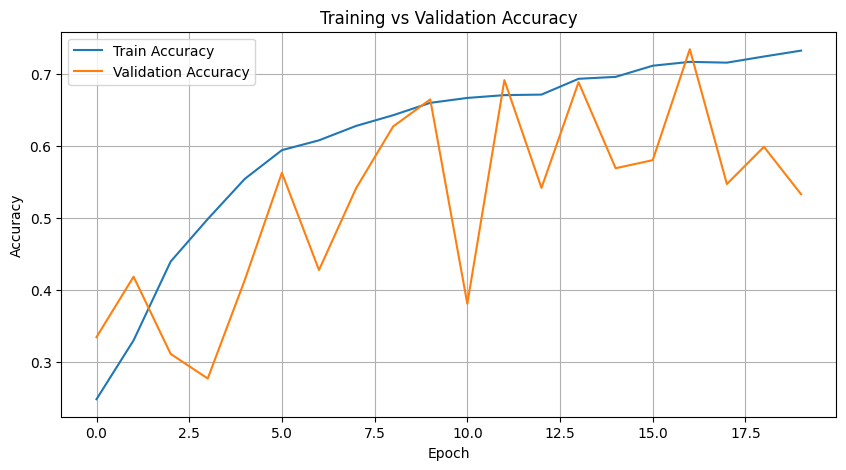

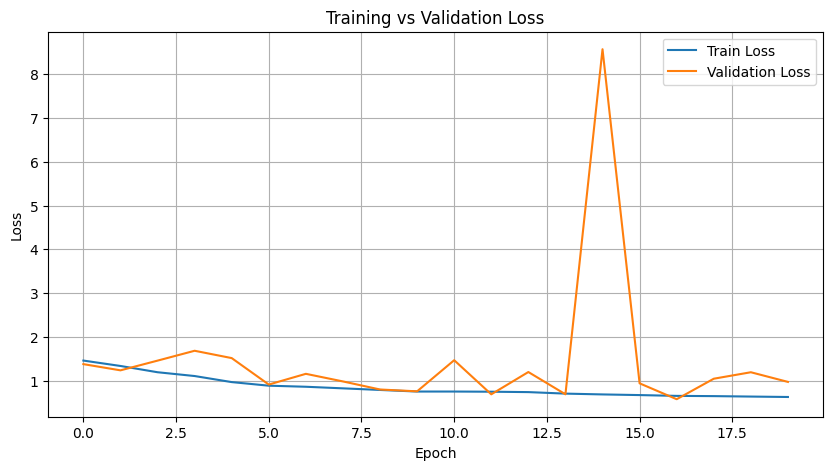

In [8]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

targets = np.array([label for _, label in full_train_dataset])
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(targets), y=targets)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize lists to store accuracies for plotting
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Early stopping variables
best_val_accuracy = 0.0
patience_counter = 0

# Training loop
for epoch in range(EPOCHS):
    model.train()
    correct_train = 0
    total_train = 0
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accuracy
        _, preds = torch.max(outputs, 1)
        correct_train += torch.sum(preds == labels.data)
        total_train += labels.size(0)
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train.double() / total_train
    train_accuracies.append(train_accuracy.item())
    train_losses.append(train_loss)

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            correct_val += torch.sum(preds == labels.data)
            total_val += labels.size(0)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_accuracy = correct_val.double() / total_val
    val_accuracies.append(val_accuracy.item())
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"- Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    # Early stopping
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")  # Save best model
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

# Plot accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.title("Training vs Validation Accuracy")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.title("Training vs Validation Loss")
plt.show()


C:\Users\Kunal\AppData\Local\Temp\ipykernel_5772\1042605793.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


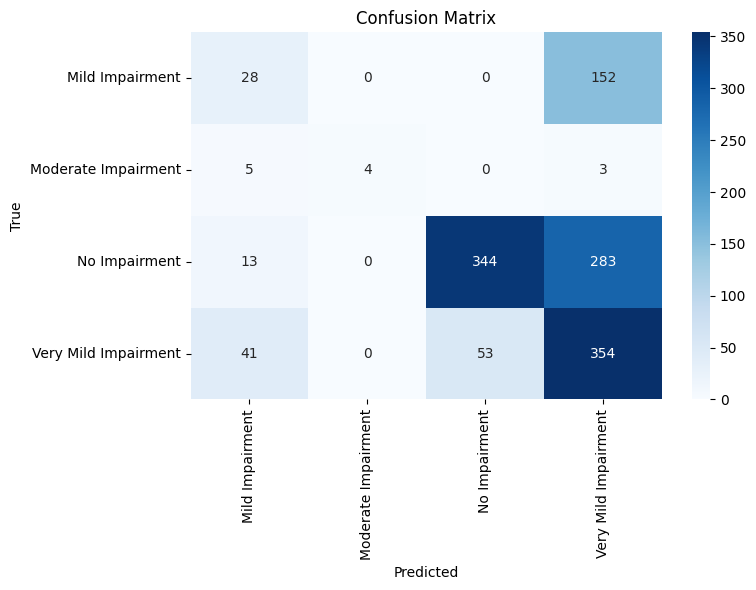

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Load best model (optional if already in memory)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Get predictions and true labels for test set
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = test_dataset.classes  # e.g., ['MildDemented', 'ModerateDemented', ...]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [10]:
from sklearn.metrics import classification_report

# Print classification report
report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:\n")
print(report)



Classification Report:

                      precision    recall  f1-score   support

     Mild Impairment       0.32      0.16      0.21       180
 Moderate Impairment       1.00      0.33      0.50        12
       No Impairment       0.87      0.54      0.66       640
Very Mild Impairment       0.45      0.79      0.57       448

            accuracy                           0.57      1280
           macro avg       0.66      0.45      0.49      1280
        weighted avg       0.64      0.57      0.57      1280

